In [1]:
%matplotlib inline

In [2]:
import sys
import traceback
import logging
import contextlib
from multiprocessing.pool import Pool

import yaml  # pyyaml
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch import multiprocessing as mp
import numpy as np
import pandas as pd
#from tqdm import tqdm_notebook  # индикатор прогресса

In [3]:
%load_ext autoreload
%autoreload 2

from dqnroute import delivperiods, ComputerNetEnv, MAIN_LOGGER

In [4]:
logger = logging.getLogger(MAIN_LOGGER)

In [21]:
plt.rc('font', size=14)

# Построение графиков
def plot_data(data, figsize=(15,10), xlim=None, ylim=None, target='avg', name=None):
    fig = plt.figure(figsize=figsize)
    
    # Данные типа pandas.DataFrame, x и y содержат названия нужных столбцов
    ax = sns.lineplot(x='time', y=target, hue='router_type', data=data)
    ax.set(xlabel="Simulation time", ylabel="Mean delivery time")
    #ax.legend(['Q', 'Link-state', 'dqn'], title='Router type');

    if xlim is not None:
        plt.xlim(xlim)
        
    if ylim is not None:
        plt.ylim(ylim)
        
    plt.show()
    
    if name is not None:
        # Директория ../img должна быть создана
        fig.savefig('../imgs/' + name, bbox_inches='tight')


# Связать результат с экспериментом
def get_job_id(router_type, seed):
    return f'{router_type}:{seed}'


def parse_job_id(job_id):
    router_type, seed = job_id.split(':')
    return router_type, int(seed)


# Добавить столбец к результатам, значения определяются построчно
def add_avg(df: pd.DataFrame):
    df['avg'] = df['sum'] / df['count']
    return df


def combine_launch_data(launch_data):
    dfs = []
    for job_id, data in launch_data.items():
        router_type, seed = parse_job_id(job_id)
        df = data.copy()
        
        # Добавляем новые столбцы с информацией о роутере и сиде
        df['router_type'] = router_type
        df['seed'] = seed
        
        dfs.append(df)
        
    # Склеиваем результаты разных экспериментов по горизонтали (друг под другом)
    res = pd.concat(dfs, axis=0)
    return res

In [8]:
def run_network_scenario_file(file: str,  # файл со структурой графа и настройками алгоритмов
                              router_type: str,
                              random_seed: int = None,
                              period_dur: int = 500,
                              period_aggrs: list[str] = ['count', 'sum', 'min', 'max']):
    # Обертка вокруг NetworkEnvironment для запуска в отдельном потоке
    
    with open(file) as f:
        run_params = yaml.safe_load(f)
    
    # Агрегатор данных
    periods = delivperiods.create_periods(period_dur, period_aggrs)
   
    env = ComputerNetEnv(run_params=run_params,
                     router_type=router_type,
                     deliv_periods=periods)
 
    # Запуск симуляции
    series = env.run(random_seed=random_seed)
    
    #print(series.records.head())
    #   time    count  sum     min   max
    #0     0.0   47.0  1941.0   5.0  72.0
    #1   500.0   49.0  1808.0   5.0  70.0
    #2  1000.0   49.0  2519.0  21.0  85.0
    #3  1500.0   50.0  2683.0  21.0  85.0
    #4  2000.0   49.0  2730.0  21.0  90.0
        
    return add_avg(periods.get_periods())

def exc_print(e):
    print(''.join(traceback.format_exception(etype=type(e), value=e, tb=e.__traceback__)))

def run_threaded(func, router_types: list[str], random_seeds: list[int], *args, **kwargs): 
    pool = Pool()
    jobs = {}
    for router_type in router_types:
        for seed in random_seeds:
            job_id = get_job_id(router_type, seed)
            job_args = dict(kwargs, router_type=router_type, random_seed=seed)
            jobs[job_id] = pool.apply_async(func, args=args, kwds=job_args,
                                            error_callback=exc_print)
        
    results = {job_id: job.get() for (job_id, job) in jobs.items()}
    
    return results

In [9]:
%ls ../torch_models

back/                                         qnetwork_8_64-64_relu_le-4
qnetwork_130_64-64_relu_oh-10_amatrix-100     qnetwork_8_64-64_relu_le-4.gz
qnetwork_130_64-64_relu_oh-10_amatrix-100.gz  tmp/


In [19]:
launch6_data_mult = run_threaded(run_network_scenario_file,
                                 file='../launches/launch6.yaml',
                                 router_types=['link_state', 'q', 'dqn', 'dqn_le'],
                                 random_seeds=[42, 43, 44])

launch6_data_comb = combine_launch_data(launch6_data_mult)

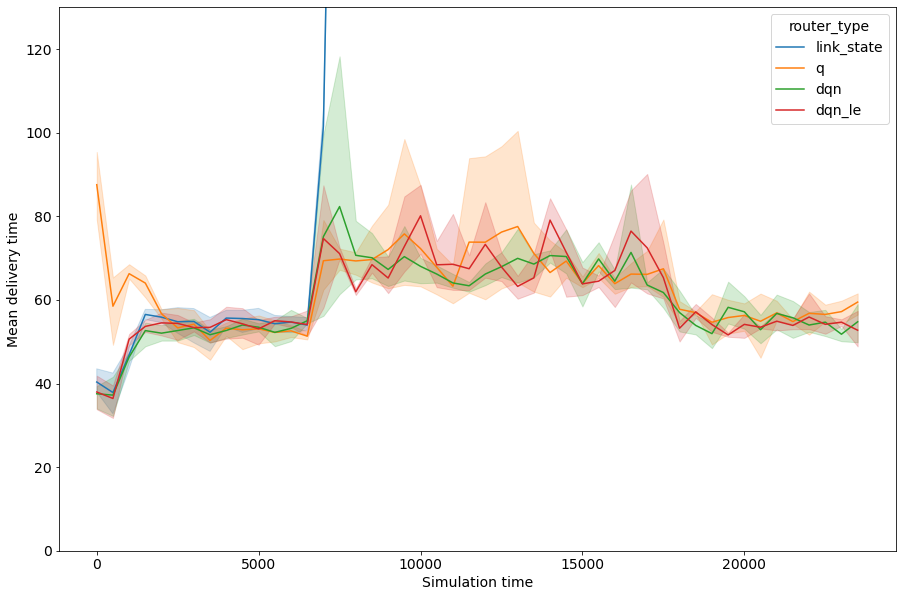

In [22]:
plot_data(launch6_data_comb, ylim=(0, 130), name="load-increase")

In [16]:
launch8_data = run_threaded(run_network_scenario_file,
                            file='../launches/launch8.yaml',
                            router_types=['link_state', 'q', 'dqn', 'dqn_le'],
                            random_seeds=[42, 43, 44])

launch8_data_comb = combine_launch_data(launch8_data)

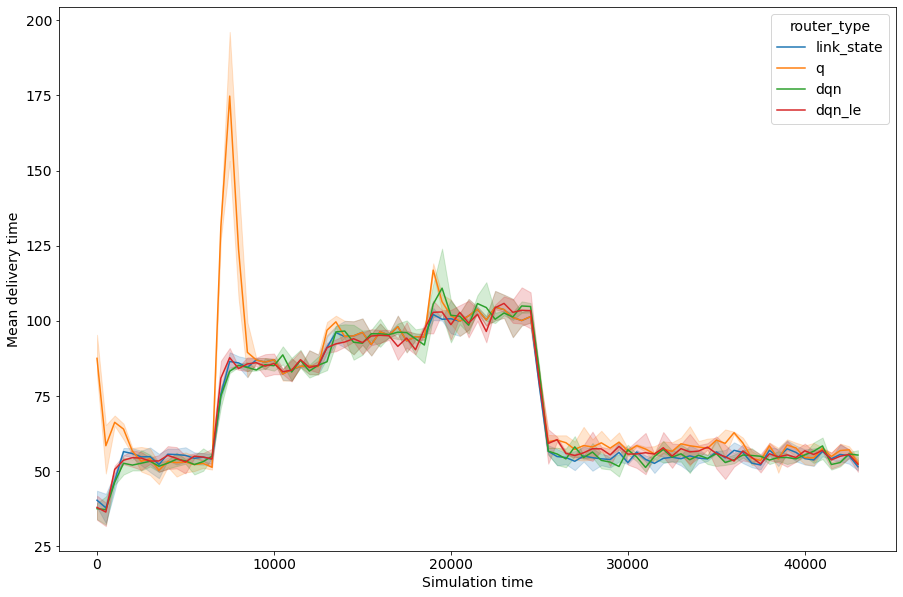

In [23]:
plot_data(launch8_data_comb, name="link-break")

In [24]:
launch10_data = run_threaded(run_network_scenario_file,
                             file='../launches/launch10.yaml',
                             router_types=['link_state', 'dqn', 'dqn_le'],
                             random_seeds=[42, 43, 44])

launch10_data_comb = combine_launch_data(launch10_data)

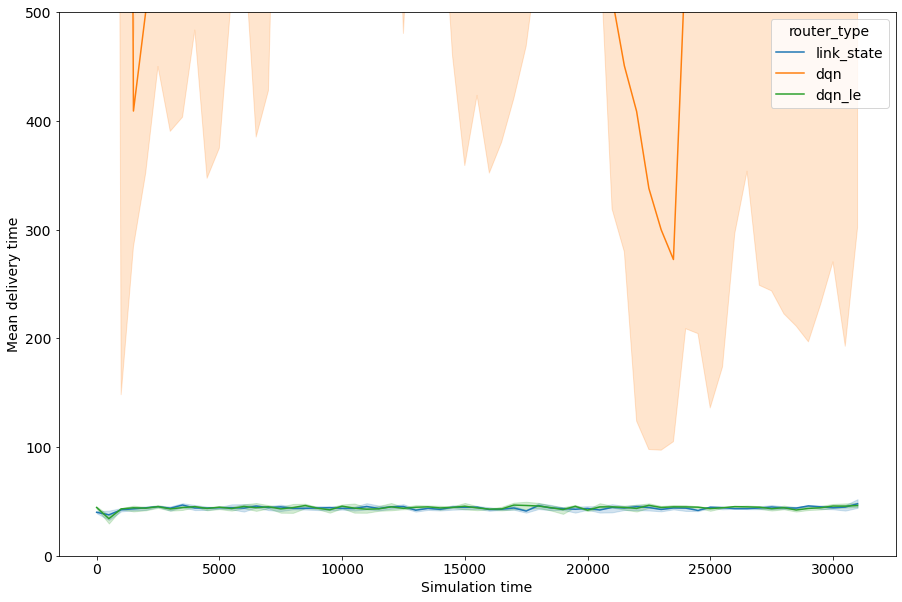

In [28]:
plot_data(launch10_data_comb, ylim=(0, 500), name="unknown-net")